## **Libraries**

In [ ]:
!pip install contractions#install contractions
!pip install tomotopy#install tomotopy

In [1]:
#Import libraries
import pandas as pd
import numpy as np
import os,glob
from google.colab import drive
from sklearn.feature_extraction.text import TfidfVectorizer
from spacy.lang.en.stop_words import STOP_WORDS as stopwords
import regex as re
import nltk
from sklearn.decomposition import NMF
from sklearn.decomposition import TruncatedSVD
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
import os  # for os.path.basename

import matplotlib.pyplot as plt
import matplotlib as mpl
import contractions
from sklearn.manifold import MDS
from scipy.cluster.hierarchy import ward, dendrogram
# import mpld3
from spacy.lang.en.stop_words import STOP_WORDS as en_stop 
from sklearn import preprocessing
import spacy
import io
import os.path
import re
import tarfile
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
import smart_open
from gensim.models import Phrases
from gensim.models.phrases import Phraser
from gensim.corpora import Dictionary
from gensim.models import LdaModel,CoherenceModel,LdaMulticore,Phrases
from tqdm import tqdm
from gensim.test.utils import datapath
import sys
import tomotopy as tp
import numpy as np

In [2]:
#mount drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
#Assign filename and import data to dataframe
filepath='/content/drive/My Drive/Datasets/Capstone/Allthenews-TM/all-the-news-2-1.csv'
df=pd.read_csv(filepath,nrows=2000000)

# EDA and Preprocessing

In [4]:
#@title
#Look at data
df=df.loc[:,'date':'publication']
df.head()

,date,year,month,day,author,title,article,url,section,publication
0,2016-12-09 18:31:00,2016,12.0,9,Lee Drutman,We should take concerns about the health of li...,"This post is part of Polyarchy, an independent...",https://www.vox.com/polyarchy/2016/12/9/138983...,NaN,Vox
1,2016-10-07 21:26:46,2016,10.0,7,Scott Davis,Colts GM Ryan Grigson says Andrew Luck's contr...,The Indianapolis Colts made Andrew Luck the h...,https://www.businessinsider.com/colts-gm-ryan-...,NaN,Business Insider
2,2018-01-26 00:00:00,2018,1.0,26,NaN,Trump denies report he ordered Mueller fired,"DAVOS, Switzerland (Reuters) - U.S. President ...",https://www.reuters.com/article/us-davos-meeti...,Davos,Reuters
3,2019-06-27 00:00:00,2019,6.0,27,NaN,France's Sarkozy reveals his 'Passions' but in...,PARIS (Reuters) - Former French president Nico...,https://www.reuters.com/article/france-politic...,World News,Reuters
4,2016-01-27 00:00:00,2016,1.0,27,NaN,Paris Hilton: Woman In Black For Uncle Monty's...,Paris Hilton arrived at LAX Wednesday dressed ...,https://www.tmz.com/2016/01/27/paris-hilton-mo...,NaN,TMZ


In [5]:
df=df[['year','month','title','article','section','publication']]
df['publication'].value_counts(dropna=False)

Reuters               676052
CNBC                  179930
The Hill              178473
People                125582
CNN                   101297
Vice                   95150
Mashable               86361
Refinery 29            80130
The New York Times     51624
TechCrunch             45834
The Verge              45514
TMZ                    43689
Vox                    42072
Axios                  41478
Politico               38131
Buzzfeed News          29896
Gizmodo                26309
Economist              22889
Fox News               20144
Wired                  17621
Vice News              15539
Hyperallergic          11683
New Republic           10924
Business Insider        9409
New Yorker              4266
Washington Post            3
Name: publication, dtype: int64

In [ ]:
#This is just to check how many of each section is in the corpus. I tried to keep around 30K of each broader topic.
df_new=df[df['section'].str.contains('Food',na=False)]#checking how many instance of individual sections are in the corpus
counts=df_new['section'].value_counts(dropna=False).reset_index(name='counts')
sec=counts[counts['counts']>0]
print(counts['counts'].sum())
print(sec)

In [6]:
#Getting only Technology, Healthcare, Business/Finance, and Entertainment sections
df=df[(df['section'].str.contains('Health',na=False))|(df['section']=='Health and Science')|(df['section'].str.contains('Entertainment',na=False))|(df['section'].str.contains('Finance',na=False))|(df['section'].str.contains('Money',na=False))| (df['section']=='Tech')|(df['section'].str.contains('Tech by VICE',na=False))]
# df.to_csv(r'/content/drive/My Drive/Datasets/Capstone/Allthenews-TM/subfolder/news-30k-postEDA_postfilter.csv')#Checkpoint

In [ ]:
#This is just to check how many of each section is in the corpus. I tried to keep around 30K of each broader topic.
counts=df['section'].value_counts(dropna=False).reset_index(name='counts')
sec=counts[counts['counts']>0]
print(counts['counts'].sum())
print(sec)

In [8]:
df.dtypes

year             int64
month          float64
title           object
article         object
section         object
publication     object
dtype: object

In [9]:
df['year']=df['year'].astype(int)
df['article']=df['article'].astype(str)
df['section']=df['section'].astype(str)
df['publication']=df['publication'].astype(str)

In [10]:
print('How much data is available for each year')
print(df['year'].value_counts())

How much data is available for each year
2017    27803
2016    25516
2018    21259
2019    11324
Name: year, dtype: int64


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0, 0.5, '# of Occurences')

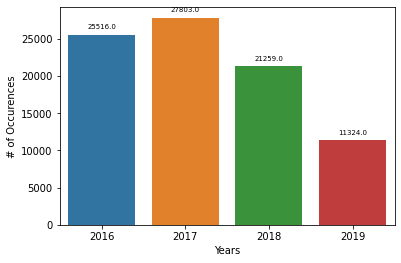

In [11]:
#Plot the yearly distibution
import seaborn as sns
import matplotlib.pyplot as plt

plots=sns.barplot(df['year'].value_counts().sort_index().reset_index(name='freq')['index'],df['year'].value_counts().sort_index().reset_index(name='freq')['freq'])
for bar in plots.patches:
  plt.annotate(format(bar.get_height()),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=7, xytext=(0, 8),
                   textcoords='offset points')
plt.xlabel("Years")
plt.ylabel("# of Occurences")

In [12]:
print('We have {} publication cells that are empty'.format(df['publication'].isnull().sum()))
print('We have {} article cells that are empty'.format(df['article'].isnull().sum()))
print('We have {} title cells that are empty'.format(df['title'].isnull().sum()))

We have 0 publication cells that are empty
We have 0 article cells that are empty
We have 1 title cells that are empty


We can ensure if article column is empty then we will get value from title column and if it is still empty then we will drop the row

In [13]:
df['article_updated']=df['article'].combine_first(df['title'])
df=df[['year','month','article_updated','section','publication']]
print('{} rows will be dropped from the combined title and article column'.format(df['article_updated'].isnull().sum()))

0 rows will be dropped from the combined title and article column


In [ ]:
#Double check dataframe
df.head()

,year,article_updated,section,publication
7,2018,If only every day could be like this. You can’...,Health,Vice
11,2019,(Reuters) - The success of Hudson’s Bay Co Exe...,Business News,Reuters
22,2018,NEW YORK (Reuters) - Wells Fargo & Co (WFC.N) ...,Business News,Reuters
24,2019,(Reuters) - Major automakers have announced a ...,Business News,Reuters
27,2019,LONDON (Reuters) - Britain’s financial service...,Business News,Reuters


In [14]:
print('We have {} publication cells that are empty'.format(df['publication'].isnull().sum()))
print('We have {} article cells that are empty'.format(df['article_updated'].isnull().sum()))

We have 0 publication cells that are empty
We have 0 article cells that are empty


In [15]:
def clean(text):
    # standalone sequences of specials, matches &# but not #cool
    text = re.sub(r'(?:^|\s)[&#<>{}\[\]+|\\:-]{1,}(?:\s|$)', ' ', text)
    # standalone sequences of hyphens like --- or ==”
    text = re.sub(r'(?:^|\s)[\-=\+]{2,}(?:\s|$)', ' ', text)
    # sequences of white spaces
    text = re.sub(r'\s+', ' ', text)
    
    
    return text.strip()
def decontracted(phrase):
    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase
def takeCharsUntilNotRoman(w):
    result = []
    for c in w:
        if ord(c) <128 or (ord(c) >= 65313 and ord(c) <= 65339) or (ord(c) >= 65345 and ord(c) <= 65371):
            result.append(c)
        else:
            break
    # Assume a word needs to be at least 2 chars long
    if len(result) > 1:
        return ''.join(result)
    return ''




In [16]:
df["article_updated"]=df["article_updated"].apply(clean)
df["article_updated"]=df["article_updated"].apply(decontracted)
df["article_updated"]=df["article_updated"].apply(takeCharsUntilNotRoman)
df["article_updated"]=df["article_updated"].apply(contractions.fix)

In [17]:
print("Mean length of document: {0:.2f}\nTotal number of documents in the corpus: {1:}".format(df['article_updated'].str.len().mean(),len(df['article_updated'])))

Mean length of document: 816.62
Total number of documents in the corpus: 85902


In [18]:
meanlength=df['article_updated'].str.len().mean()
print("{0:.2f}% of the documents are greater than mean length document length".format((np.sum(df['article_updated'].str.len()>meanlength)/len(df['article_updated']))*100))

29.58% of the documents are greater than mean length document length


In [ ]:
#This is just a process to check the impurity of each document i.e. documents containing bad text (bad text length from document/total docuemnt length ). Only relevant for EDA
imp=[]
RE_SUSPICIOUS=re.compile(r'[&#<>{}\[\]\\]')
def impurity(text,min_len=10):
  # returns bad text
  if text==None or len(text)<min_len:
    return 0
  else:
    return len(RE_SUSPICIOUS.findall(text))/len(text)

[imp.append(impurity(df["article_updated"][i])) for i,text in enumerate(df["article_updated"])]
  
print('Impurity: ',np.mean(imp))

Impurity:  0.00011102961787308563


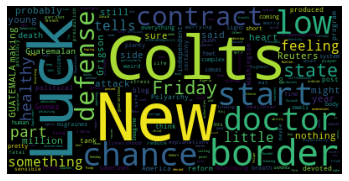

In [ ]:
#Checking on prominent words in the corpus. EDA relevant
from wordcloud import WordCloud
import matplotlib.pyplot as plt
text = df['article_updated'].values 

wordcloud = WordCloud().generate(str(text))

plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [ ]:
# df.to_csv(r'/content/drive/My Drive/Datasets/Capstone/Allthenews-TM/subfolder/news-30k-postEDA.csv')#checkpoint

# HLDA Tomo

In [19]:
#@title
#add redundant words to stop words
en_stop.add("said")
en_stop.add("reuters")
en_stop.add("london")
en_stop.add("new york")
en_stop.add('reuters')
en_stop.add('say')
en_stop.add('like')
en_stop.add('thing')
en_stop.add('york')
en_stop.add('new')

In [20]:
def preprocess(docs,col,phrasecount,filter_extremes=True):
    # Split the documents into tokens.
  tokenizer = RegexpTokenizer(r'\w+')
  for idx in range(len(col)):
      docs[idx] = docs[idx].lower()  # Convert to lowercase.
      docs[idx] = tokenizer.tokenize(docs[idx])  # Split into words.
      # print(docs[idx])
  # Remove numbers, but not words that contain numbers.
  docs = [[token for token in doc if not token.isnumeric()] for doc in docs]
  # print(docs)
  # Remove words that are only one character.
  docs = [[token for token in doc if len(token) > 1] for doc in docs]
  # print(docs)
  docs = [[token for token in doc if token not in en_stop] for doc in docs]
  # print(docs)
  nltk.download('wordnet')
  lemmatizer = WordNetLemmatizer()  
  docs = [[lemmatizer.lemmatize(token) for token in doc] for doc in docs]
  # print(docs)
  # Add bigrams and trigrams to docs (only ones that appear 20 times or more).
  bigram = Phrases(docs, min_count=phrasecount)
  for idx in range(len(docs)):
      for token in bigram[docs[idx]]:
          if '_' in token:
              # Token is a bigram, add to document.
              docs[idx].append(token)
  # Create a dictionary representation of the documents.
  dictionary = Dictionary(docs)

  # Filter out words that occur less than 20 documents, or more than 50% of the documents.
  if filter_extremes:
    dictionary.filter_extremes(no_below=phrasecount,no_above=0.5)
  corpus = [dictionary.doc2bow(doc) for doc in docs]
  print('-----------------------------------------')
  print('Number of unique tokens: %d' % len(dictionary))
  print('Number of documents: %d' % len(corpus))
  return dictionary,corpus

#The below function just gets the top 5 word for each topic after training has been done on LDA  
def display_topics_gensim(model,topper=5):
    for topic in range(0, model.num_topics):
        print("\nTopic %02d" % topic)
        for (word, prob) in model.show_topic(topic, topn=topper):
            print("  %s (%2.2f)" % (word, prob))

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


/usr/local/lib/python3.7/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


-----------------------------------------
Number of unique tokens: 19186
Number of documents: 75394


100%|██████████| 18/18 [52:28<00:00, 174.89s/it]


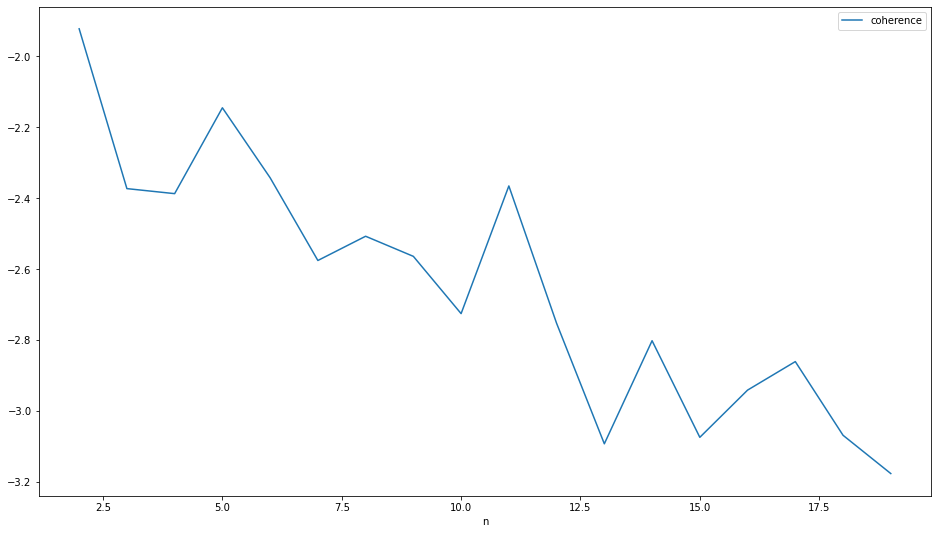

In [ ]:
from gensim.models.ldamulticore import LdaMulticore#This is a faster model

dictionary,bow_gensim_para=preprocess(list(df['article_updated']),df['article_updated'],20) #Get the dictionary and corpus
lda_para_model_n = []
temp = dictionary[0]  # This is only to "load" the dictionary.
dict_gensim_para = dictionary.id2token
for n in tqdm(range(2, 20)):
  lda_model = LdaMulticore(corpus=bow_gensim_para, id2word=dict_gensim_para,
                              chunksize=2000, eta='auto', iterations=400,
                              num_topics=n, passes=5, eval_every=None,
                              random_state=42)
  lda_coherence = CoherenceModel(model=lda_model, corpus=bow_gensim_para, coherence='u_mass')#this runs the coherence model to get coherence per loop
  lda_para_model_n.append((n, lda_model, lda_coherence.get_coherence()))#we then append it to to a list
pd.DataFrame(lda_para_model_n, columns=["n", "model", \
    "coherence"]).set_index("n")[["coherence"]].plot(figsize=(16,9))#plot to see the trend over training

In [ ]:
df_coherence=pd.DataFrame(lda_para_model_n, columns=["n", "model", "coherence"]).set_index("n")
# new_num_topics=df_coherence[[df_coherence['coherence']==df_coherence['coherence'].max()]['n']]

In [ ]:
dictionary.save('/content/drive/My Drive/fourthbrain/capstone/subsample2/dict')#storing dictionary

In [23]:
import json#corpus is not needed for inference but saving if needed in future
with open("/content/drive/My Drive/fourthbrain/capstone/subsample2/corp.json", 'w') as f:
    json.dump(corpus, f, indent=2) 

In [25]:
# Train LDA model.
dictionary,corpus=preprocess(list(df['article_updated']),df['article_updated'],20)

# Set training parameters.
num_topics = 4
chunksize = 2000
passes = 10
iterations = 5000
eval_every = None  # Don't evaluate model perplexity, takes too much time.
# Make a index to word dictionary.
temp = dictionary[0]  # This is only to "load" the dictionary.
id2word = dictionary.id2token
ldamodel = LdaMulticore(corpus=corpus,id2word=id2word, chunksize=chunksize, iterations=iterations, num_topics=num_topics, passes=passes, eval_every=eval_every)

In [26]:
display_topics_gensim(ldamodel,15)


Topic 00
  company (0.02)
  year (0.01)
  apple (0.01)
  billion (0.01)
  percent (0.01)
  million (0.01)
  amazon (0.01)
  market (0.01)
  facebook (0.01)
  business (0.01)
  share (0.01)
  service (0.01)
  cnbc (0.00)
  ceo (0.00)
  quarter (0.00)

Topic 01
  health (0.01)
  people (0.01)
  state (0.01)
  year (0.01)
  tax (0.00)
  care (0.00)
  trump (0.00)
  drug (0.00)
  study (0.00)
  percent (0.00)
  according (0.00)
  plan (0.00)
  patient (0.00)
  american (0.00)
  case (0.00)

Topic 02
  million (0.03)
  company (0.03)
  source (0.02)
  coverage (0.02)
  text (0.02)
  source_text (0.02)
  say (0.02)
  ltd (0.01)
  company_coverage (0.01)
  co (0.01)
  newsroom (0.01)
  chinese (0.01)
  share (0.01)
  year (0.01)
  eikon (0.01)

Topic 03
  time (0.00)
  year (0.00)
  people (0.00)
  user (0.00)
  video (0.00)
  facebook (0.00)
  game (0.00)
  work (0.00)
  film (0.00)
  way (0.00)
  world (0.00)
  day (0.00)
  google (0.00)
  company (0.00)
  feature (0.00)


In [27]:
ldamodel.save('/content/drive/My Drive/fourthbrain/capstone/subsample2/lda/test-lda')#checkpoint--->save the lda model

In [28]:
#Get topic for each document in corpus
def format_topics_sentences(ldamodel=ldamodel, corpus=corpus, texts=df['article_updated']):
    # Init output
    sent_topics_df = pd.DataFrame()
    counter=0
    counterinsiderow=0
    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        counter+=1
        
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # print(row)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            # print(topic_num)
            # print(prop_topic)
            
            if j == 0:  # => dominant topic
                counterinsiderow+=1
                wp = ldamodel.show_topic(topic_num)
                # print(wp)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
            
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=ldamodel, corpus=corpus, texts=df['article_updated'])


In [29]:
sum(df_topic_sents_keywords['Dominant_Topic'].isna())

0

In [30]:
df.reset_index(drop=True,inplace=True)#reset index since we filtered the corpus for certain sections

In [31]:
contents = pd.Series(df['article_updated'])
df_topic_sents_keywords_new = pd.concat([df_topic_sents_keywords, contents], axis=1)
df_topic_sents_keywords_new.shape
df_dominant_topic = df_topic_sents_keywords_new.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

In [33]:
sum(df_dominant_topic['Text'].isna())

0

In [34]:
df_dominant_topic['Dominant_Topic'].value_counts()#check the frequency per topic

3.0    37877
1.0    17834
0.0    15123
2.0    15068
Name: Dominant_Topic, dtype: int64

In [35]:
df_dominant_topic.to_csv(r'/content/drive/My Drive/fourthbrain/capstone/subsample2/df-dom.csv')#save df as csv

In [52]:
#function to get hierarchy for each topic corpus with tomotopy hlda
def hlda_example(save_path,corp,corpus,size):
    from nltk.stem.porter import PorterStemmer
    from nltk.corpus import stopwords
    cps=corpus
    np.random.seed(42)
    ridcs = np.random.permutation(len(cps))
    train_idcs = ridcs[:size]
    test_idcs = ridcs[size:]

    test_cps = cps[test_idcs]
    train_cps = cps[train_idcs]
    mdl = tp.HLDAModel(tw=tp.TermWeight.ONE, min_df=5, depth=3,  corpus=train_cps)
    mdl.train(0)
    print('Num docs:', len(mdl.docs), ', Vocab size:', len(mdl.used_vocabs), ', Num words:', mdl.num_words)
    print('Removed top words:', mdl.removed_top_words)
    print('Training...', file=sys.stderr, flush=True)
    for _ in range(0, 100, 10):
        mdl.train(7)
        mdl.train(3, freeze_topics=True)
        print('Iteration: {:05}\tll per word: {:.5f}\tNum. of topics: {}'.format(mdl.global_step, mdl.ll_per_word, mdl.live_k))

    for _ in range(0, 100, 10):
        mdl.train(10, freeze_topics=True)
        print('Iteration: {:05}\tll per word: {:.5f}\tNum. of topics: {}'.format(mdl.global_step, mdl.ll_per_word, mdl.live_k))

    mdl.summary()
    print('Saving...', file=sys.stderr, flush=True)
    mdl.save(save_path, True)
    corpus_tomo.save(corp)

    test_result_cps, ll = mdl.infer(test_cps)
    for doc in test_result_cps:
        print(doc.path, doc.get_words(top_n=10))
    return mdl


In [ ]:
#automate the process of running hlda on multiple topics generated by the lda. At the end of training each hlda model, the model is saved.
for i in np.unique(df_dominant_topic['Dominant_Topic']).astype(int):#for each unique topic in lda
  df_loop=df_dominant_topic.loc[(df_dominant_topic['Dominant_Topic']==i)] #get the documents with the loop topic
  nltk.download('wordnet')
  lemmatizer = WordNetLemmatizer()  

  pat = re.compile('\w+')
  #create corpus function 
  corpus_tomo = tp.utils.Corpus(
          tokenizer=tp.utils.SimpleTokenizer(stemmer=None,lowercase=True), 
          stopwords=lambda x: len(x) <= 2 or x in en_stop or x.isnumeric() or not pat.match(x) or not lemmatizer.lemmatize(x)
      )
  newsgroups_train = df_loop['Text']
  corpus_tomo.process(d.lower() for d in newsgroups_train)#send the loop topic documents through the corpus utility
  hlda_example('/content/drive/My Drive/fourthbrain/capstone/subsample2/test-hlda'+str(i)+'.tmm','/content/drive/My Drive/fourthbrain/capstone/subsample2/test-corpus'+str(i)+'.cached.cps',corpus_tomo,df_loop.shape[0]-5)#store it in the path mentioned. the shape-5 is just to have some testing documents for the model, else it would error out.


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Training...


Num docs: 14043 , Vocab size: 14844 , Num words: 1537411
Removed top words: []
Iteration: 00010	ll per word: -inf	Num. of topics: 150
Iteration: 00020	ll per word: -inf	Num. of topics: 261
Iteration: 00030	ll per word: -inf	Num. of topics: 332
Iteration: 00040	ll per word: -inf	Num. of topics: 377
Iteration: 00050	ll per word: -inf	Num. of topics: 413
Iteration: 00060	ll per word: -inf	Num. of topics: 444
Iteration: 00070	ll per word: -inf	Num. of topics: 468
Iteration: 00080	ll per word: -inf	Num. of topics: 483
Iteration: 00090	ll per word: -inf	Num. of topics: 499
Iteration: 00100	ll per word: -inf	Num. of topics: 514
Iteration: 00110	ll per word: -inf	Num. of topics: 501
Iteration: 00120	ll per word: -inf	Num. of topics: 495
Iteration: 00130	ll per word: -inf	Num. of topics: 492
Iteration: 00140	ll per word: -inf	Num. of topics: 492
Iteration: 00150	ll per word: -inf	Num. of topics: 491
Iteration: 00160	ll per word: -inf	Num. of topics: 491
Iteration: 00170	ll per word: -inf	Num. o

Saving...


|     #259 (1537, 37) : apple tariffs china products trump
|     #260 (1329, 44) : million funding didi round billion
|     #261 (422, 16) : medicare humana plans health inc
|     #262 (649, 13) : irs bitcoin coinbase tax gains
|     #263 (597, 21) : adobe digital cloud software narayen
|     #264 (363, 12) : start-ups israel san francisco cisco
|     #265 (926, 19) : symantec company equifax trading breach
|     #266 (874, 30) : china fintech financial asset management
|     #267 (1428, 41) : banks european brexit bank vote
|     #268 (836, 16) : espn disney skipper media cable
|     #269 (449, 10) : micron huawei china united states
|     #271 (1901, 86) : amazon bezos jeff billion ceo
|     #272 (1411, 52) : paypal square company payments payment
|     #273 (524, 11) : tesla china cars vehicles model
|     #274 (602, 13) : anthem health plans obamacare insurer
|     #275 (244, 4) : tesla stations trucks charging semi
|     #276 (722, 46) : pounds drug british sales funding
|     #27

Training...


Num docs: 17828 , Vocab size: 15740 , Num words: 1238025
Removed top words: []
Iteration: 00010	ll per word: -inf	Num. of topics: 271
Iteration: 00020	ll per word: -inf	Num. of topics: 377
Iteration: 00030	ll per word: -inf	Num. of topics: 468
Iteration: 00040	ll per word: -inf	Num. of topics: 538
Iteration: 00050	ll per word: -inf	Num. of topics: 582
Iteration: 00060	ll per word: -inf	Num. of topics: 631
Iteration: 00070	ll per word: -inf	Num. of topics: 659
Iteration: 00080	ll per word: -inf	Num. of topics: 680
Iteration: 00090	ll per word: -inf	Num. of topics: 704
Iteration: 00100	ll per word: -inf	Num. of topics: 711
Iteration: 00110	ll per word: -inf	Num. of topics: 697
Iteration: 00120	ll per word: -inf	Num. of topics: 695
Iteration: 00130	ll per word: -inf	Num. of topics: 692
Iteration: 00140	ll per word: -inf	Num. of topics: 690
Iteration: 00150	ll per word: -inf	Num. of topics: 687
Iteration: 00160	ll per word: -inf	Num. of topics: 686
Iteration: 00170	ll per word: -inf	Num. o

Saving...


|     #326 (170, 6) : attacks havana affected symptoms patients
|   #123 (1161, 170) : cosby bill judge comedian assault
|     #119 (720, 37) : federal court guilty morgan metals
|     #140 (815, 114) : los angeles court britain wednesday
|     #170 (87, 19) : dolores verdict dublin pigs slaughter
|   #124 (170, 17) : whales sanctuary whale south international
|     #218 (138, 10) : carolina oregon portland charleston south
|     #535 (98, 7) : wilderness earth square area miles
|   #125 (601, 76) : bacteria antibiotics infections resistant image
|     #131 (249, 24) : cells venom vaccine culture time
|     #155 (197, 24) : nuclear hawaii emergency disaster quake
|     #461 (235, 7) : water scarcity year team global
|     #474 (187, 14) : different skin noise signal drug
|     #508 (100, 7) : harvey surgery rub hands fingers
|   #126 (359, 23) : median home beach older retirement
|     #135 (268, 23) : island miami city list coast
|   #127 (97, 9) : city background uber austin checks
|

Training...


Num docs: 15062 , Vocab size: 4675 , Num words: 334389
Removed top words: []
Iteration: 00010	ll per word: -inf	Num. of topics: 148
Iteration: 00020	ll per word: -inf	Num. of topics: 176
Iteration: 00030	ll per word: -inf	Num. of topics: 192


In [38]:
model= LdaModel.load('/content/drive/My Drive/fourthbrain/capstone/subsample2/lda/test-lda')
mdl0= tp.HLDAModel.load('/content/drive/My Drive/fourthbrain/capstone/subsample2/test-hlda0.tmm')
mdl1= tp.HLDAModel.load('/content/drive/My Drive/fourthbrain/capstone/subsample2/test-hlda1.tmm')
mdl2= tp.HLDAModel.load('/content/drive/My Drive/fourthbrain/capstone/subsample2/test-hlda2.tmm')
mdl3= tp.HLDAModel.load('/content/drive/My Drive/fourthbrain/capstone/subsample2/test-hlda3.tmm')


In [47]:
cluster_names = {#name the clusters as seems reasonable
    0: "Science and Technology",#tech and business
    1: "Health/Science/Drugs",#health
    2: "Business/Tech/BioTech",#business
    3: "Entertainment/News" 
}
#Test articles
# other_texts = {'txt':['The human genome is made up of about 3.1 billion DNA subunits, pairs of chemical bases known by the letters A, C, G and T. Genes are strings of these lettered pairs that contain instructions for making proteins, the building blocks of life. Humans have about 30,000 genes, organized in 23 groups called chromosomes that are found in the nucleus of every cell']}
# other_texts = {'txt':['Oliveira missed championship weight by half a pound at the official weigh-ins, using up almost the entirety of the initial two-hour window before making his first attempt and then taking another hour before stepping to the scale again. Both times he came in at 155.5 pounds. His UFC 274 main event challenger Justin Gaethje showed up minutes after the weigh-ins began, hitting 155 on the dot. It was later announced that Oliveira would be stripped of his title and that only Gaethje would be eligible to leave Footprint Center in Phoenix with the belt around his waist.']}
# other_texts = {'txt':['The Centre for Creative and Immersive XR (extended reality - an umbrella term for all types of digital reality, from the immersive VR viewed in headsets, to AR games like Pokemon Go, in which graphics are posted over the real world as seen through a smartphone camera) has received more than £5m in funding, including a £3.6m government grant']}
# other_texts = {'txt':['Rooftop solar has a “huge potential” to cut air pollution, create jobs, protect against outages and shrink utility bills, said Mark Jacobson, a professor of civil and environmental engineering at Stanford University. The technology will be vital for the U.S. to make the transition to all-renewable energy by 2050, he said.']}
# other_texts = {'txt':['The Kings finalized a deal with Brown on Sunday after meeting with him over two days late last week, sources said. Brown comes to the Kings with a clear organizational mandate: End the longest playoff drought in NBA history and return the Kings to the postseason for the first time in 16 years.']}
# other_texts = {'txt':['Patients with KRAS-mutant colorectal cancers do not respond to cetuximab, a monoclonal antibody against EGFR. A new proof-of-concept study presents a bispecific antibody with the ability to trigger EGFR degradation in LGR5+ cancer stem cells, and robust anti-tumor activity in KRAS-mutant and wild-type colorectal cancers.']}
other_texts = {'txt':['Bitcoin continued to slide after a broader stock sell-off in the U.S. last week sent the cryptocurrency market into a frenzy and prompted bitcoin to plummet by roughly 10%. Bitcoin, the world’s largest digital currency by market value, was lower by about 3% at $33,438.03 late Sunday, according to data from Coin Metrics. This year, Bitcoin has been trading in a narrow range as it attempts to reclaim its highs of late 2021. The cryptocurrency is now down 50% from its peak price of $67,802.30 in November 2021. The drop comes after the blue-chip Dow Jones Industrial Average lost more than 1,000 points on Thursday and the Nasdaq plunged by 5%. Those losses marked the worst single-day drops since 2020. The Dow and Nasdaq fell again on Friday. \
# \ Meanwhile, the Federal Reserve on Wednesday raised its benchmark interest rate by half a percentage point as it responds to inflation pressures.\
# \ The stock market rallied after Fed chair Jerome Powell said a larger rate hike of 75 basis points isn’t being considered. But by Thursday, investors had erased the Fed rally’s gains.\
# \ The global cryptocurrency market cap was at $1.68 trillion on Sunday, according to data from CoinGecko.com, and cryptocurrency trading volume in the last day was at $119 billion.']}
#--------------
other_texts=pd.DataFrame(other_texts) #Convert dictionary to dataframe
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()  

pat = re.compile('\w+')
corpus_unseen = tp.utils.Corpus(
        tokenizer=tp.utils.SimpleTokenizer(stemmer=None,lowercase=True), 
        stopwords=lambda x: len(x) <= 2 or x in en_stop or x.isnumeric() or not pat.match(x) or not lemmatizer.lemmatize(x)
    )
unseen = other_texts['txt']
corpus_unseen.process(d.lower() for d in unseen)

dict_gensim,corpus_gensim=preprocess(list(other_texts['txt']),other_texts['txt'],1,False) #Preprocess the dataframe
unseen_doc = corpus_gensim[0]
vector = model[unseen_doc]  # get topic probability distribution for a document
topic_number, proba = sorted(vector, key=lambda item: item[1])[-1]
topic_number2, proba2 = sorted(vector, key=lambda item: item[1])[-2]#thinking of using the second topic only, since first doesnt change--decide later

tn=0
if proba>0.49:#increased to 0.49 for selecting first topic so that we see it only if the model is atleast 50% positive, else not worth it
  tn=topic_number
else:
  tn=topic_number2
if proba < 0.2:
  print(-1, -1)
else:
  print(cluster_names.get(topic_number), proba)
  print(cluster_names.get(topic_number2), proba2)
hldamdl=tp.HLDAModel()
if tn==0:
  hldamdl=mdl0
elif tn==1:
  hldamdl=mdl1
elif tn==2:
  hldamdl=mdl2
elif tn==3:
  hldamdl=mdl3


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
-----------------------------------------
Number of unique tokens: 91
Number of documents: 1
Entertainment/News--entertainment 0.7824971
Science and Technology-tech&biz 0.21300118


/usr/local/lib/python3.7/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [48]:
mdls=[mdl0,mdl1,mdl2,mdl3]
lst=[]
for i in mdls:
  itest_result_cps, ill=i.infer(corpus_unseen)
  lst.append((itest_result_cps,abs(ill)))
  s1=other_texts['txt'][0]
maxll=max(lst,key=lambda item:item[1])[1]
maxcps=max(lst,key=lambda item:item[1])[0]
max_index = lst.index((maxcps,maxll))
md=mdls[max_index]

for doc in maxcps:
    for path in doc.path:
      if path==0:
        print('Root Topic is {}'.format(cluster_names.get(max_index)))
        print('Subtopics Level {}:\n{}'.format(path,[i[0] for i in md.get_topic_words(path)]))
      else:
        print('Subtopics Level {}:\n{}'.format(path,[i[0] for i in md.get_topic_words(path)]))
    print('Original Unseen Word|Probability pairs:\n{}'.format(doc.get_words(top_n=10)))

skdict={'Root':[],
        'ST0':[],
        'ST1':[],
        'ST2':[],
        'ST3':[],
        'Prob':[]}
skdict['Root'].append(cluster_names.get(max_index))
for doc in maxcps:
    for i,path in enumerate(doc.path):
        skdict['ST'+str(i)].append([i[0] for i in md.get_topic_words(path)])
for word,prob in doc.get_words(top_n=10):
  skdict['ST3'].append(word)
  skdict['Prob'].append(prob)



Root Topic is Entertainment/News--entertainment
Subtopics Level 0:
['people', 'company', 'facebook', 'data', 'according', 'told', 'internet', 'motherboard', 'twitter', 'information']
Subtopics Level 8:
['time', 'people', 'world', 'years', 'work', 'way', 'life', 'know', 'year', 'day']
Subtopics Level 202:
['shkreli', 'stewart', 'martin', 'fund', 'wrote', 'hedge', 'drug', 'pharma', 'price', 'wu-tang']
Original Unseen Word|Probability pairs:
[('bitcoin', 0.03773584961891174), ('cryptocurrency', 0.03773584961891174), ('market', 0.03773584961891174), ('dow', 0.01886792480945587), ('stock', 0.01886792480945587), ('rate', 0.01886792480945587), ('trading', 0.01886792480945587), ('data', 0.01886792480945587), ('late', 0.01886792480945587), ('according', 0.01886792480945587)]


In [ ]:
#Tree structure with one random topic selected from level 1
print('Root Topic 0:   \t\t{}'.format(cluster_names.get(max_index)))
offbranchtopiclevel2=md.children_topics(0)[:2]
for doc in maxcps:
    for i,path in enumerate(doc.path):
      if path==0:
        # print('Root Topic is {}'.format(cluster_names.get(max_index)))
        # print('Subtopics Level {}:\n{}'.format(path,[i[0] for i in md.get_topic_words(path)]))
        continue
      elif i==1:
        offbranchtopiclevel1=[j for j in md.children_topics(0) if j!=path]
        print('\n{}:{} \t\tAND\t\t {}:{} '.format(path,[i[0] for i in md.get_topic_words(path)][:2],offbranchtopiclevel1[0],[i[0] for i in md.get_topic_words(offbranchtopiclevel1[0])][:2]))
      elif i==2:
        offbranchtopiclevel2=[j for j in md.children_topics(offbranchtopiclevel1[0]) if j!=path]
        print('\n{}:{} \t\tAND\t\t {}:{} '.format(path,[i[0] for i in md.get_topic_words(path)][:2],offbranchtopiclevel2[0],[i[0] for i in md.get_topic_words(offbranchtopiclevel2[0])][:2]))
        # print('\n{}:{}'.format(path,[i[0] for i in md.get_topic_words(path)]))
    print('\n\n\n\nOriginal Unseen Word|Probability pairs:\n{}'.format(doc.get_words(top_n=10)))

Root Topic 0:   		Health/Science/Drugs

115:['testing', 'gonorrhea'] 		AND		 63:['cfo', 'evotec'] 

138:['screening', 'health'] 		AND		 328:['sedation', 'injection'] 




Original Unseen Word|Probability pairs:
[('egfr', 0.0833333358168602), ('antibody', 0.0833333358168602), ('colorectal', 0.0833333358168602), ('cancers', 0.0833333358168602), ('proof-of-concept', 0.0416666679084301), ('ability', 0.0416666679084301), ('bispecific', 0.0416666679084301), ('cells', 0.0416666679084301), ('cancer', 0.0416666679084301), ('presents', 0.0416666679084301)]


In [ ]:
#2 levels with first level from HLDA and 2nd level from LDA
print('Root Topic:   \t\t\t\t{}'.format(cluster_names.get(max_index)))
print('Level 1: ({}->{})\t \t({}->{})'.format(cluster_names.get(topic_number), proba,cluster_names.get(topic_number2), proba2))

Root Topic:   				Health/Science/Drugs
Level 1: (Business/Tech/BioTech->0.41334280371665955)	 	(Science and Technology->0.3569861054420471)
